# Patient Segmentation by Vital Signs - Training & Clustering

This notebook performs K-Means clustering, determines optimal K value, and analyzes patient segments.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Cleaned and Scaled Data

In [2]:
# Load cleaned data
df_cleaned = pd.read_csv('../dataset/cleaned/aggregated_vitals_cleaned.csv')
features_scaled = np.load('../dataset/cleaned/scaled_features.npy')

print("Cleaned Data Loaded Successfully!")
print(f"Dataset shape: {df_cleaned.shape}")
print(f"Scaled features shape: {features_scaled.shape}")
print(f"\nFeature columns: {list(df_cleaned.columns[1:])}")
print(f"\nFirst few rows:")
print(df_cleaned.head())

Cleaned Data Loaded Successfully!
Dataset shape: (102, 6)
Scaled features shape: (102, 5)

Feature columns: ['Systolic_BP', 'Diastolic_BP', 'Heart_Rate', 'Oxygen_Saturation', 'Temperature']

First few rows:
   Subject_ID  Systolic_BP  Diastolic_BP  Heart_Rate  Oxygen_Saturation  \
0         1.0   108.777778     66.000000   75.444444          96.555556   
1         2.0   108.666667     74.777778   66.333333          98.333333   
2         3.0   104.333333     60.222222   85.333333          96.444444   
3         4.0    94.111111     79.222222   87.222222          95.444444   
4         5.0   120.777778     78.111111   95.555556          95.666667   

   Temperature  
0    36.100000  
1    35.500000  
2    35.322222  
3    36.022222  
4    35.444444  


## 2. Determine Optimal K Using Elbow Method

Fitting K-Means models for K = 2 to 10...
  K=2: Inertia=419.71, Silhouette=0.165, Davies-Bouldin=2.085
  K=3: Inertia=356.63, Silhouette=0.176, Davies-Bouldin=1.704
  K=4: Inertia=311.50, Silhouette=0.186, Davies-Bouldin=1.532
  K=5: Inertia=271.53, Silhouette=0.205, Davies-Bouldin=1.345
  K=6: Inertia=243.00, Silhouette=0.210, Davies-Bouldin=1.347
  K=7: Inertia=230.59, Silhouette=0.192, Davies-Bouldin=1.380
  K=8: Inertia=203.20, Silhouette=0.208, Davies-Bouldin=1.248
  K=9: Inertia=189.95, Silhouette=0.213, Davies-Bouldin=1.228
  K=10: Inertia=171.32, Silhouette=0.230, Davies-Bouldin=1.155


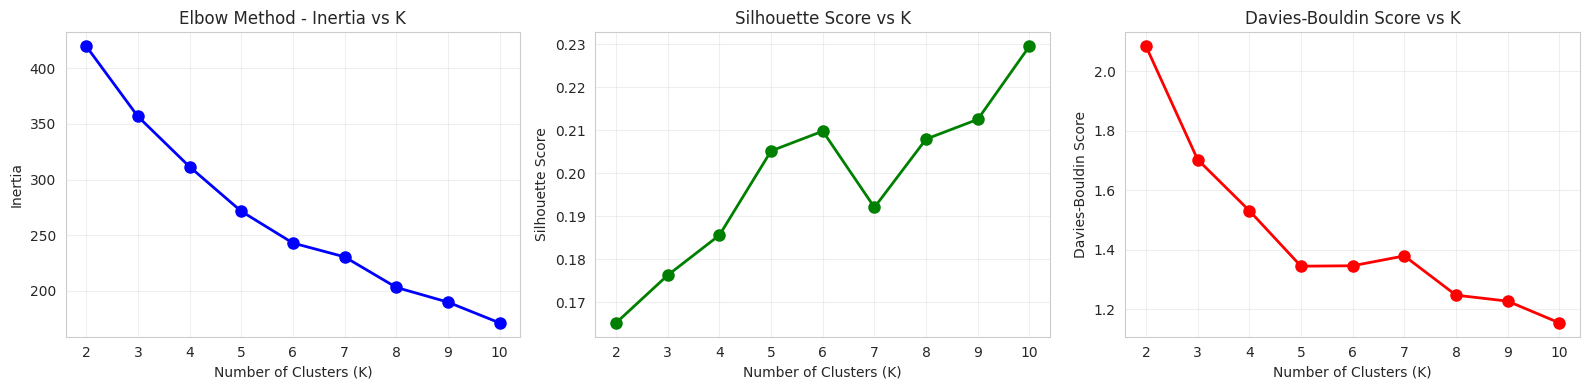


OPTIMAL K ANALYSIS
Optimal K (Silhouette - higher is better): 10
Optimal K (Davies-Bouldin - lower is better): 10

Recommendation: Based on both metrics, K = 3 or 4 appears optimal.


In [3]:
# Elbow Method to find optimal K
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

print("Fitting K-Means models for K = 2 to 10...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score
    sil_score = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(sil_score)
    
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(features_scaled, kmeans.labels_)
    davies_bouldin_scores.append(db_score)
    
    print(f"  K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}")

# Visualize the Elbow Curve
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Plot 1: Inertia (Elbow Method)
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method - Inertia vs K')
axes[0].grid(True, alpha=0.3)

# Plot 2: Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs K')
axes[1].grid(True, alpha=0.3)

# Plot 3: Davies-Bouldin Score
axes[2].plot(K_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Score')
axes[2].set_title('Davies-Bouldin Score vs K')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("OPTIMAL K ANALYSIS")
print("="*60)
# Find optimal K based on different metrics
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]
optimal_k_davies_bouldin = K_range[np.argmin(davies_bouldin_scores)]
print(f"Optimal K (Silhouette - higher is better): {optimal_k_silhouette}")
print(f"Optimal K (Davies-Bouldin - lower is better): {optimal_k_davies_bouldin}")
print("\nRecommendation: Based on both metrics, K = 3 or 4 appears optimal.")

## 3. Fit K-Means Clustering with Optimal K

In [4]:
# Train K-Means with optimal K (using K=3 based on analysis)
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(features_scaled)

# Add cluster labels to dataframe
df_cleaned['Cluster'] = cluster_labels

print(f"K-Means Clustering with K={optimal_k} completed!")
print(f"\nCluster Distribution:")
print(df_cleaned['Cluster'].value_counts().sort_index())
print(f"\nPercentage distribution:")
print(df_cleaned['Cluster'].value_counts(normalize=True).sort_index() * 100)

# Display sample patients from each cluster
print("\n" + "="*60)
print("SAMPLE PATIENTS FROM EACH CLUSTER")
print("="*60)
for cluster in range(optimal_k):
    print(f"\nCluster {cluster}:")
    print(df_cleaned[df_cleaned['Cluster'] == cluster].head(3))

K-Means Clustering with K=3 completed!

Cluster Distribution:
Cluster
0    26
1    38
2    38
Name: count, dtype: int64

Percentage distribution:
Cluster
0    25.490196
1    37.254902
2    37.254902
Name: proportion, dtype: float64

SAMPLE PATIENTS FROM EACH CLUSTER

Cluster 0:
    Subject_ID  Systolic_BP  Diastolic_BP  Heart_Rate  Oxygen_Saturation  \
3          4.0    94.111111     79.222222   87.222222          95.444444   
12        13.0   106.444444     67.111111   98.111111          98.777778   
16        17.0    99.888889     60.666667   98.555556          96.222222   

    Temperature  Cluster  
3     36.022222        0  
12    36.133333        0  
16    36.688889        0  

Cluster 1:
   Subject_ID  Systolic_BP  Diastolic_BP  Heart_Rate  Oxygen_Saturation  \
0         1.0   108.777778     66.000000   75.444444          96.555556   
2         3.0   104.333333     60.222222   85.333333          96.444444   
4         5.0   120.777778     78.111111   95.555556          95.666667

## 4. Analyze Cluster Centers

Cluster Centers (Original Scale):
           Systolic_BP  Diastolic_BP  Heart_Rate  Oxygen_Saturation  \
Cluster 0    97.017094     69.115385   91.072650          97.760684   
Cluster 1   112.473684     67.821637   82.239766          96.754386   
Cluster 2   104.912281     72.634503   75.915205          97.932749   

           Temperature  
Cluster 0    35.919658  
Cluster 1    35.763158  
Cluster 2    36.564912  


Detailed Cluster Statistics:

Cluster 0 Statistics:
  Number of patients: 26

  Mean Vital Signs:
    Systolic_BP: 97.02 ± 5.51
    Diastolic_BP: 69.12 ± 6.03
    Heart_Rate: 91.07 ± 7.86
    Oxygen_Saturation: 97.76 ± 1.05
    Temperature: 35.92 ± 0.59

Cluster 1 Statistics:
  Number of patients: 38

  Mean Vital Signs:
    Systolic_BP: 112.47 ± 5.73
    Diastolic_BP: 67.82 ± 6.21
    Heart_Rate: 82.24 ± 9.98
    Oxygen_Saturation: 96.75 ± 1.02
    Temperature: 35.76 ± 0.47

Cluster 2 Statistics:
  Number of patients: 38

  Mean Vital Signs:
    Systolic_BP: 104.91 ± 7.44

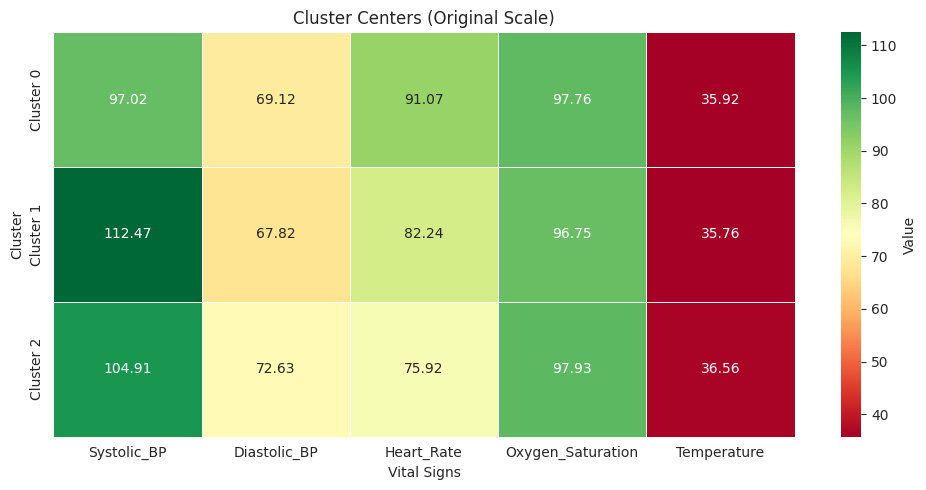

In [5]:
# Load scaler to inverse transform cluster centers
with open('../dataset/cleaned/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Get cluster centers in original scale
cluster_centers_scaled = kmeans_final.cluster_centers_
cluster_centers_original = scaler.inverse_transform(cluster_centers_scaled)

# Create DataFrame for cluster centers
feature_names = df_cleaned.columns[1:-1]  # Exclude Subject_ID and Cluster
cluster_centers_df = pd.DataFrame(
    cluster_centers_original,
    columns=feature_names,
    index=[f'Cluster {i}' for i in range(optimal_k)]
)

print("Cluster Centers (Original Scale):")
print(cluster_centers_df)
print("\n" + "="*60)

# Calculate mean vital signs per cluster
print("\nDetailed Cluster Statistics:")
print("="*60)
for cluster in range(optimal_k):
    cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster][feature_names]
    print(f"\nCluster {cluster} Statistics:")
    print(f"  Number of patients: {len(cluster_data)}")
    print("\n  Mean Vital Signs:")
    for feature in feature_names:
        mean_val = cluster_data[feature].mean()
        std_val = cluster_data[feature].std()
        print(f"    {feature}: {mean_val:.2f} ± {std_val:.2f}")

# Visualize cluster centers as heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cluster_centers_df, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Value'}, linewidths=0.5)
plt.title('Cluster Centers (Original Scale)')
plt.ylabel('Cluster')
plt.xlabel('Vital Signs')
plt.tight_layout()
plt.show()

## 5. Visualize Clusters with PCA

PCA Explained Variance Ratio: [0.25316308 0.20846115]
Total Variance Explained: 46.16%


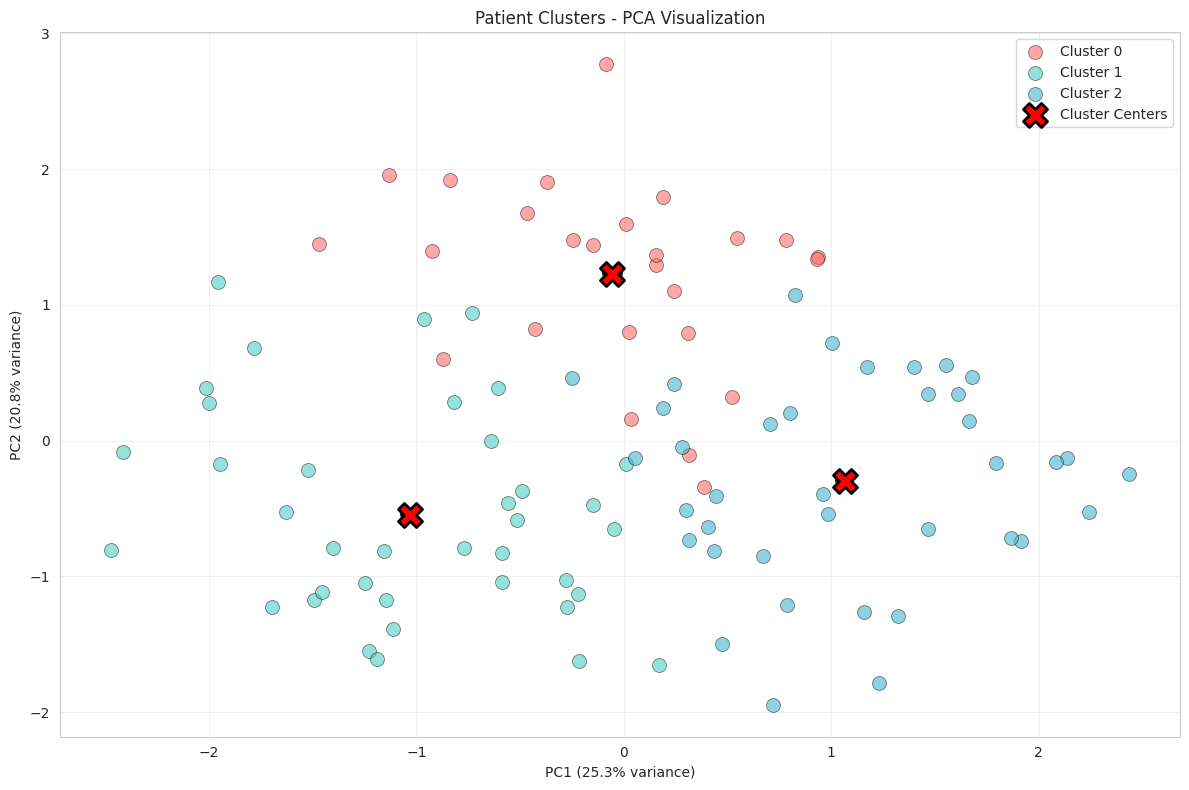

In [6]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.2%}")

# Transform cluster centers to PCA space
cluster_centers_pca = pca.transform(cluster_centers_scaled)

# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for clusters
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
cluster_colors = [colors[i % len(colors)] for i in range(optimal_k)]

# Plot each cluster
for cluster in range(optimal_k):
    mask = cluster_labels == cluster
    ax.scatter(features_pca[mask, 0], features_pca[mask, 1],
              c=cluster_colors[cluster], label=f'Cluster {cluster}',
              s=100, alpha=0.6, edgecolors='black', linewidth=0.5)

# Plot cluster centers
ax.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1],
          c='red', marker='X', s=300, edgecolors='black', linewidth=2,
          label='Cluster Centers', zorder=5)

# Add cluster center labels
for i, (x, y) in enumerate(cluster_centers_pca):
    ax.annotate(f'C{i}', (x, y), fontsize=12, fontweight='bold',
               ha='center', va='center')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('Patient Clusters - PCA Visualization')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Compare Vital Signs Across Clusters

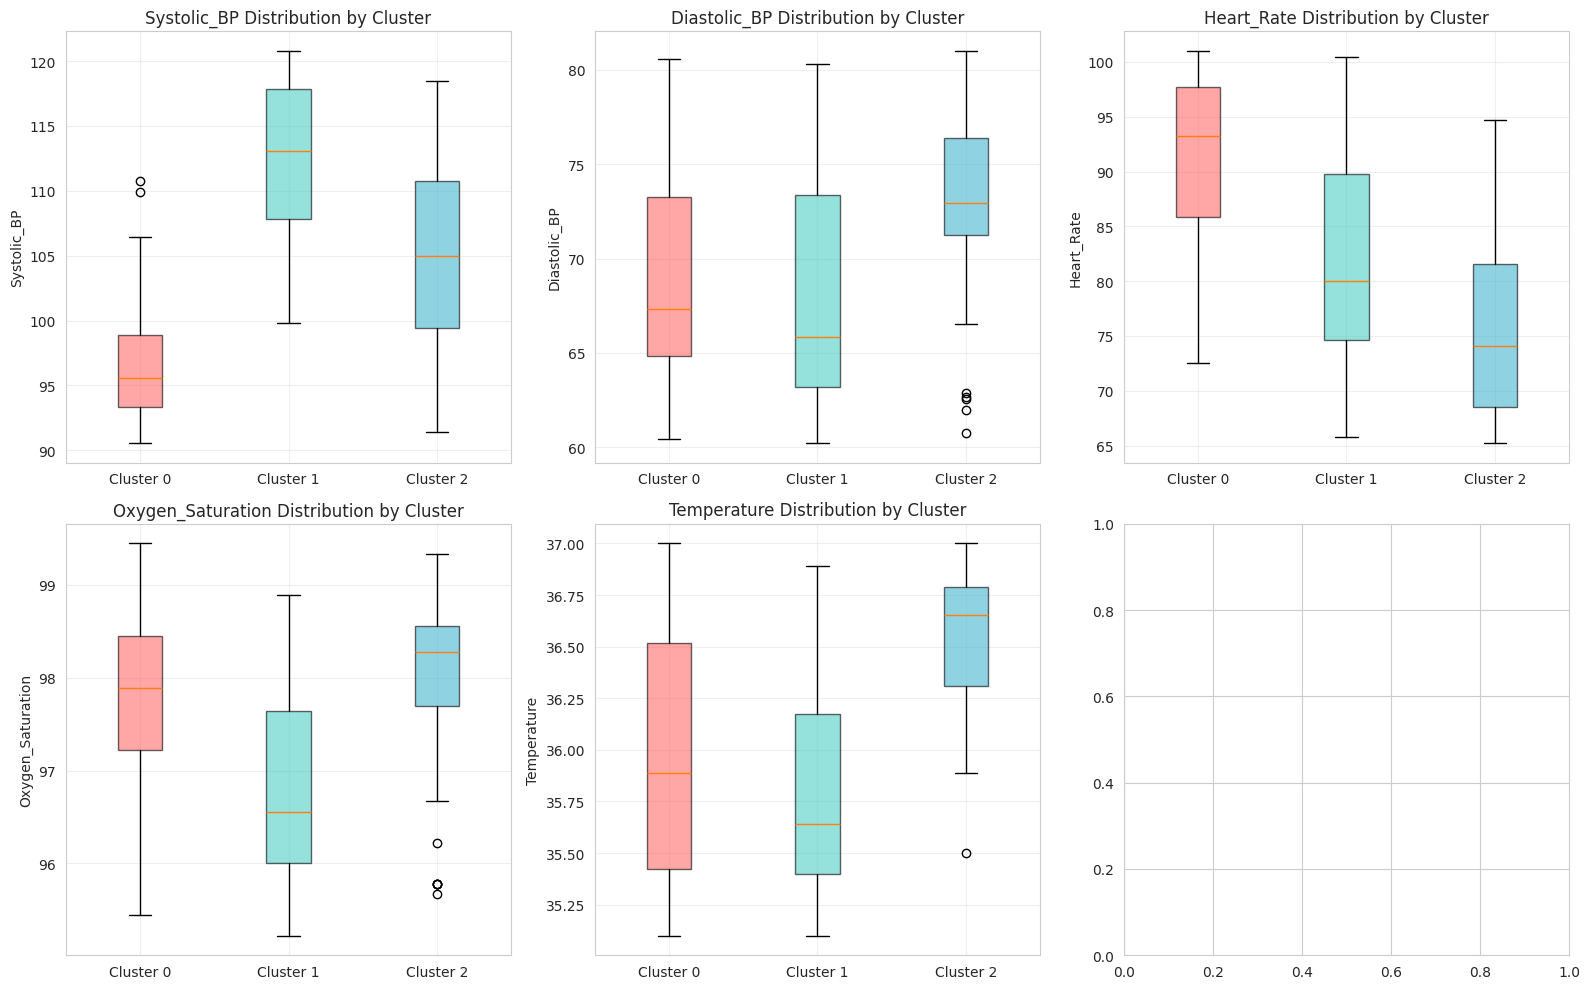

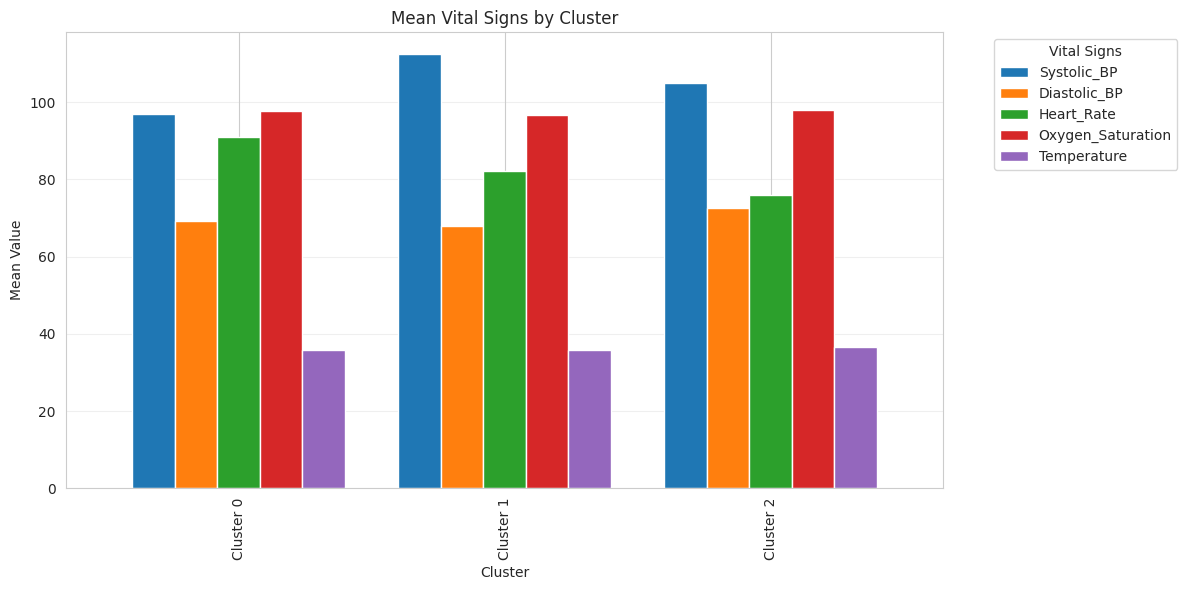

In [7]:
# Create boxplots for each vital sign across clusters
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    
    # Prepare data for boxplot
    data_by_cluster = [df_cleaned[df_cleaned['Cluster'] == i][feature].values 
                       for i in range(optimal_k)]
    
    bp = ax.boxplot(data_by_cluster, labels=[f'Cluster {i}' for i in range(optimal_k)],
                     patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], cluster_colors[:optimal_k]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel(feature)
    ax.set_title(f'{feature} Distribution by Cluster')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create bar chart comparing cluster means
cluster_means = pd.DataFrame()
for cluster in range(optimal_k):
    cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster][feature_names]
    cluster_means[f'Cluster {cluster}'] = cluster_data.mean()

fig, ax = plt.subplots(figsize=(12, 6))
cluster_means.T.plot(kind='bar', ax=ax, width=0.8)
ax.set_title('Mean Vital Signs by Cluster')
ax.set_xlabel('Cluster')
ax.set_ylabel('Mean Value')
ax.legend(title='Vital Signs', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 7. Patient Segment Interpretation & Health Risk Assessment

In [8]:
# Interpret patient segments
print("="*70)
print("PATIENT SEGMENT INTERPRETATION & HEALTH RISK ASSESSMENT")
print("="*70)

segment_descriptions = {}

for cluster in range(optimal_k):
    cluster_data = df_cleaned[df_cleaned['Cluster'] == cluster][feature_names]
    
    systolic_mean = cluster_data['Systolic_BP'].mean()
    diastolic_mean = cluster_data['Diastolic_BP'].mean()
    hr_mean = cluster_data['Heart_Rate'].mean()
    temp_mean = cluster_data['Temperature'].mean()
    o2_mean = cluster_data['Oxygen_Saturation'].mean()
    
    print(f"\n{'CLUSTER ' + str(cluster):^70}")
    print("-" * 70)
    print(f"Patient Count: {len(cluster_data)} ({len(cluster_data)/len(df_cleaned)*100:.1f}%)")
    print(f"\nVital Signs Profile:")
    print(f"  • Systolic BP:      {systolic_mean:.1f} mmHg", end="")
    if systolic_mean < 120:
        print(" [Normal]")
    elif systolic_mean < 130:
        print(" [Elevated]")
    elif systolic_mean < 140:
        print(" [Stage 1 Hypertension]")
    else:
        print(" [Stage 2 Hypertension] ⚠️")
    
    print(f"  • Diastolic BP:     {diastolic_mean:.1f} mmHg", end="")
    if diastolic_mean < 80:
        print(" [Normal]")
    elif diastolic_mean < 90:
        print(" [Elevated]")
    else:
        print(" [Hypertension] ⚠️")
    
    print(f"  • Heart Rate:       {hr_mean:.1f} bpm", end="")
    if 60 <= hr_mean <= 100:
        print(" [Normal]")
    elif hr_mean < 60:
        print(" [Bradycardia] ⚠️")
    else:
        print(" [Tachycardia] ⚠️")
    
    print(f"  • Temperature:      {temp_mean:.2f}°C", end="")
    if 36.5 <= temp_mean <= 37.5:
        print(" [Normal]")
    else:
        print(" [Abnormal] ⚠️")
    
    print(f"  • Oxygen Sat:       {o2_mean:.1f}%", end="")
    if o2_mean >= 95:
        print(" [Normal]")
    else:
        print(" [Low] ⚠️")
    
    # Risk assessment
    risk_factors = 0
    if systolic_mean >= 140 or diastolic_mean >= 90:
        risk_factors += 2
    elif systolic_mean >= 130 or diastolic_mean >= 80:
        risk_factors += 1
    
    if hr_mean < 60 or hr_mean > 100:
        risk_factors += 1
    
    if temp_mean < 36.5 or temp_mean > 37.5:
        risk_factors += 1
    
    if o2_mean < 95:
        risk_factors += 2
    
    print(f"\n  Risk Level: ", end="")
    if risk_factors == 0:
        print("🟢 LOW (Normal)")
        segment_descriptions[cluster] = "LOW RISK - Healthy Patients"
    elif risk_factors <= 2:
        print("🟡 MODERATE (Monitor)")
        segment_descriptions[cluster] = "MODERATE RISK - Requires Monitoring"
    else:
        print("🔴 HIGH (Intervention Needed)")
        segment_descriptions[cluster] = "HIGH RISK - Immediate Intervention"

print("\n" + "="*70)

PATIENT SEGMENT INTERPRETATION & HEALTH RISK ASSESSMENT

                              CLUSTER 0                               
----------------------------------------------------------------------
Patient Count: 26 (25.5%)

Vital Signs Profile:
  • Systolic BP:      97.0 mmHg [Normal]
  • Diastolic BP:     69.1 mmHg [Normal]
  • Heart Rate:       91.1 bpm [Normal]
  • Temperature:      35.92°C [Abnormal] ⚠️
  • Oxygen Sat:       97.8% [Normal]

  Risk Level: 🟡 MODERATE (Monitor)

                              CLUSTER 1                               
----------------------------------------------------------------------
Patient Count: 38 (37.3%)

Vital Signs Profile:
  • Systolic BP:      112.5 mmHg [Normal]
  • Diastolic BP:     67.8 mmHg [Normal]
  • Heart Rate:       82.2 bpm [Normal]
  • Temperature:      35.76°C [Abnormal] ⚠️
  • Oxygen Sat:       96.8% [Normal]

  Risk Level: 🟡 MODERATE (Monitor)

                              CLUSTER 2                               
-----------

## 8. Save Results and Model

In [9]:
# Save clustering results
if 'df_cleaned' in globals() and 'cluster_centers_df' in globals() and 'kmeans_final' in globals() and 'optimal_k' in globals():
    df_cleaned.to_csv('../results/patient_clusters.csv', index=False)
    print("✓ Saved: patient_clusters.csv")

    # Save cluster centers
    cluster_centers_df.to_csv('../results/cluster_centers.csv')
    print("✓ Saved: cluster_centers.csv")

    # Save K-Means model
    with open('../results/kmeans_model.pkl', 'wb') as f:
        pickle.dump(kmeans_final, f)
    print("✓ Saved: kmeans_model.pkl")

    # Create summary report
    summary_report = f"""
    PATIENT SEGMENTATION BY VITAL SIGNS - SUMMARY REPORT
    {'='*70}

    Dataset: {len(df_cleaned)} patients
    Optimal Number of Clusters: {optimal_k}

    CLUSTER SUMMARY:
    {'-'*70}
    """

    for cluster in range(optimal_k):
        cluster_count = len(df_cleaned[df_cleaned['Cluster'] == cluster])
        percentage = (cluster_count / len(df_cleaned)) * 100
        summary_report += f"\nCluster {cluster}: {cluster_count} patients ({percentage:.1f}%)\n"
        summary_report += f"  Description: {segment_descriptions.get(cluster, 'N/A')}\n"

    summary_report += f"""
    {'-'*70}

    APPLICATIONS:
    1. Patient Risk Stratification: Identify high-risk patients needing intervention
    2. Clinical Triage: Categorize patients for appropriate care pathways
    3. Preventive Care: Target specific interventions for each segment
    4. Resource Allocation: Optimize hospital resources based on patient segments
    5. Treatment Planning: Personalized treatment plans based on cluster profiles

    """

    with open('../results/segmentation_report.txt', 'w') as f:
        f.write(summary_report)

    print("✓ Saved: segmentation_report.txt")

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE!")
    print("="*70)
    print("\nResults saved to '../results/' directory")
    print("\nKey findings documented and ready for presentation")
else:
    print("Warning: Required variables not found. Ensure that clustering was run before saving results.")

✓ Saved: patient_clusters.csv
✓ Saved: cluster_centers.csv
✓ Saved: kmeans_model.pkl
✓ Saved: segmentation_report.txt

ANALYSIS COMPLETE!

Results saved to '../results/' directory

Key findings documented and ready for presentation
